# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model. 

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business. 

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:** 
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions. 

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

**Installing surprise library**

In [2]:
!pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [3]:
import warnings                                 # Used to ignore the warning given as output of the code
warnings.filterwarnings('ignore')

import numpy as np                              # Basic libraries of python for numeric and dataframe computations
import pandas as pd

import matplotlib.pyplot as plt                 # Basic library for data visualization
import seaborn as sns                           # Slightly advanced library for data visualization

from collections import defaultdict             # A dictionary output that does not raise a key error

from sklearn.metrics import mean_squared_error  # A performance metrics in sklearn

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [4]:
df = pd.read_csv('C:/Users/argop/OneDrive/Desktop/Python/GL Assignments/Recommendation system/Data/ratings_Electronics.csv', header = None) # There are no headers in the data file

# Adding column names
df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] 

# Dropping timestamp
df = df.drop('timestamp', axis = 1) 

In [5]:
print('The number of observations in the final data:', len(df))
print('Number of unique USERS in Raw data:', df['user_id'].nunique())
print('Number of unique ITEMS in Raw data:', df['prod_id'].nunique())

The number of observations in the final data: 7824482
Number of unique USERS in Raw data: 4201696
Number of unique ITEMS in Raw data: 476002


In [6]:
df.head()

,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [7]:
df.groupby(['user_id', 'prod_id']).count()['rating'].sum()

7824482

#### There are 7.8 Mn ratings in the dataset, which is same as the number of rows. This ensures there is one rating for each user and prouct (item). There is no instance of multiple ratings for each user and product.

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Also, The unique number of users in the original dataset is 4.2 Mn and the unique number of products/items in the original dataset is 0.5 Mn. So out of the total combination of 2,000 Bn, only 7.8 Mn cases are rated. Hence, **the fraction known in the original dataset is 0.0004%.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product. 

In [8]:
df_v1 = df.copy(deep = True)

In [9]:
df_v1.head()

,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [10]:
# Get the column containing the users
users = df_v1.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:        
        ratings_count[user] += 1
  
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [11]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_v1 = df_v1.loc[ ~ df_v1.user_id.isin(remove_users)]

In [12]:
# Get the column containing the products
prods = df_v1.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:
    
    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1
    
    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1    

In [13]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df_v1.loc[~ df_v1.prod_id.isin(remove_users)]

In [14]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [15]:
# Check the number of rows and columns and provide observations
# Rows
print("number of rows : ", df_final.shape[0])
 
# Columns
print("number of columns : ", df_final.shape[1])

number of rows :  65290
number of columns :  3


The number of rows in the reduced dataset is 65K, number of columns remain the same as before.

### **Data types**

In [16]:
# Check Data types and provide observations
print(df_final.info())

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB
None


Rating is the only numeric variable, User id and Product id are object variables. Also, all the columns have 65,290 non-null values. This means there is no NAN null values in the dataset

### **Checking for missing values**

In [17]:
# Check for missing values present and provide observations
print("Count total NaN at each column in a DataFrame: \n ", df_final.isnull().sum())
print("No missing values in any column in the data")

Count total NaN at each column in a DataFrame: 
  user_id    0
prod_id    0
rating     0
dtype: int64
No missing values in any column in the data


As seen earlier, no null values in the dataset for any of the columns

In [18]:
duplicate = df_final[df_final.duplicated()]
 
print("Duplicate Rows :")
 
# Print the resultant Dataframe
duplicate

Duplicate Rows :


,user_id,prod_id,rating


No duplicate rows

### **Summary Statistics**

In [19]:
# Summary statistics of 'rating' variable and provide observations
df_final[['rating']].describe().applymap('{:,.1f}'.format).T

,count,mean,std,min,25%,50%,75%,max
rating,"65,290.0",4.3,1.0,1.0,4.0,5.0,5.0,5.0


<Axes: xlabel='rating'>

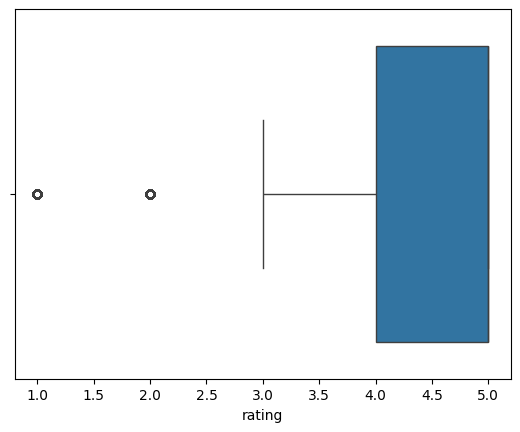

In [20]:
sns.boxplot(x = 'rating', data = df_final)

The mean value is 4.3 and standard deviation is 1. The median value is 5, indicating high number of 5-star rating provided by users. This is also seen in the box plot which is highly skewed towards the right

### **Checking the rating distribution**

<Figure size 1000x400 with 0 Axes>

Text(0.5, 1.0, 'Distribution of ratings')

Text(0.5, 0, 'Ratings')

Text(0, 0.5, 'Number of Ratings')

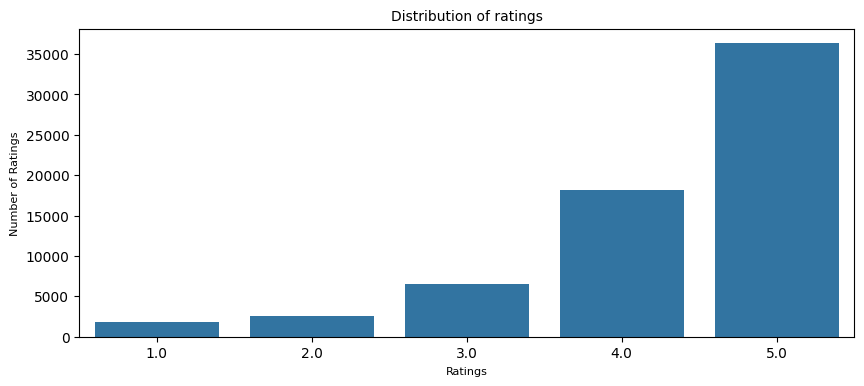

In [21]:
# Create the bar plot and provide observations
plt.figure(figsize=(10,4))
ax=sns.countplot(x='rating',data=df_final)

plt.title("Distribution of ratings", fontsize=10)
plt.xlabel("Ratings", fontsize=8)
plt.ylabel("Number of Ratings", fontsize=8)
plt.show()

In [22]:
print("The percentage distibution of the Rating values in the Final dataset:")
display(df_final['rating'].value_counts(normalize=True))

print("The percentage distibution of the Original values in the Final dataset:")
display(df['rating'].value_counts(normalize=True))

The percentage distibution of the Rating values in the Final dataset:


rating
5.0    0.556211
4.0    0.277638
3.0    0.099265
2.0    0.038520
1.0    0.028366
Name: proportion, dtype: float64

The percentage distibution of the Original values in the Final dataset:


rating
5.0    0.555633
4.0    0.189889
1.0    0.115249
3.0    0.080909
2.0    0.058320
Name: proportion, dtype: float64

Bar plot of rating values shows **56% of the ratings are 5-star** provided by users. This is the reason for the median rating value of 5-star and the distribution is highly skewed to the right in the boxplot.

The distribution of the ratings doesn't change from the original dataset to the final dataset. Hence, the final dataset can be used for further recommendation system model development

### **Checking the number of unique users and items in the dataset**

In [23]:
# Number of total rows in the data and number of unique user id and product id in the data

print('The number of observations in the final data:', len(df_final))
print('Number of unique USERS in Raw data:', df_final['user_id'].nunique())
print('Number of unique ITEMS in Raw data:', df_final['prod_id'].nunique())

The number of observations in the final data: 65290
Number of unique USERS in Raw data: 1540
Number of unique ITEMS in Raw data: 5689


In [24]:
df_final.groupby(['user_id', 'prod_id']).count()['rating'].sum()

65290

1. In the 65K row dataset, the unique number of users is 1,540 and the unique number of products / items is 5,689. We will be utilziing this dataset for further analysis.
2. Out of the total combination of 8.8 Mn user and product combinations, 65K have ratings. Thus the **Fraction known in the focused final dataset is 0.745%**

### **Users with the most number of ratings**

In [25]:
# Top 10 users based on the number of ratings
most_rated = df_final.groupby('user_id').size().sort_values(ascending = False)[:10]
most_rated

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A22CW0ZHY3NJH8    193
A1UQBFCERIP7VJ    193
AWPODHOB4GFWL     184
A3LGT6UZL99IW1    179
dtype: int64

The highest number of ratings by a user is 295. The total number of unique products in the final dataset is 5,689. 

Thus there are many products that are not rated and hence a recommendation model can be developed to determine the ratings for the products not rated

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [26]:
# Calculate the average rating for each product 
average_rating = df_final.groupby('prod_id')['rating'].mean().to_frame()
average_rating = average_rating.rename(columns={'rating':'Avg_rating'})
average_rating.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5689 entries, 1400501466 to B00LGQ6HL8
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Avg_rating  5689 non-null   float64
dtypes: float64(1)
memory usage: 88.9+ KB


In [27]:
# Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id')['rating'].count().to_frame()
count_rating = count_rating.rename(columns={'rating':'Num_rating'})
count_rating.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5689 entries, 1400501466 to B00LGQ6HL8
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Num_rating  5689 non-null   int64
dtypes: int64(1)
memory usage: 88.9+ KB


In [28]:
# Create a dataframe with calculated average and count of ratings
final_rating = pd.merge(average_rating,count_rating,on="prod_id",how="inner")
final_rating.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5689 entries, 1400501466 to B00LGQ6HL8
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Avg_rating  5689 non-null   float64
 1   Num_rating  5689 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 133.3+ KB


In [29]:
# Sort the dataframe by average of ratings in the descending order
final_rating=final_rating.sort_values(by=['Avg_rating'],ascending=[False])

In [30]:
# See the first five records of the "final_rating" dataset
final_rating.head()

,Avg_rating,Num_rating
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [31]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
    
def top_products(data, num, min_prod):
    
    
    Top = final_rating[final_rating['Num_rating'] >= min_prod]
    
    
    Top = Top.sort_values(by=['Avg_rating'],ascending=[False])
    
    return Top.head(num)

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [32]:
top_products(final_rating, 5, 50)

,Avg_rating,Num_rating
prod_id,,
B001TH7GUU,4.871795,78
B003ES5ZUU,4.864130,184
B0019EHU8G,4.855556,90
B006W8U2MU,4.824561,57
B000QUUFRW,4.809524,84


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [33]:
top_products(final_rating, 5, 100)

,Avg_rating,Num_rating
prod_id,,
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B002WE6D44,4.770000,100
B007WTAJTO,4.701220,164
B002V88HFE,4.698113,106


We have recommended the **top 5** products by using the popularity recommendation system. This approach can be used if the all the users are new to the platform and we don't know the historical ratings given by the users for the products/items.


Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [34]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them. 

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [35]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)
    
    # Making predictions on the test data
    predictions = model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    
    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    
    accuracy.rmse(predictions)
    
    print('Precision: ', precision) # Command to print the overall precision
    
    print('Recall: ', recall) # Command to print the overall recall
    
    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [36]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (1, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 99)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **2.A.i Building the user-user Similarity-based Recommendation System**

In [37]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options=sim_options,verbose=False, random_state = 1)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(sim_user_user, 10, 3.5)

RMSE: 1.0142
Precision:  0.858
Recall:  0.865
F_1 score:  0.861


1. The RMSE of 1.0142 is not great since its above 1
2. The precision of 0.858 and recall of 0.865 are  both good, which means that the model is correctly identifying both the relevant and non-relevant items. 
3. The F1 score of 0.861 is a good indication that the model should performing well overall

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [38]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.33   {'actual_k': 6, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.3333333333333335, details={'actual_k': 6, 'was_impossible': False})

The actual rating given by the user for the item (r_ui) is 5, while the model's estimate of the rating (est) is 3.33. This means that the user-user based model is underestimating the user's rating for the item.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [39]:
# Find unique user_id where prod_id is not equal to "1400501466"
df_product_not_interacted=df_final[df_final['prod_id'] != "1400501466"]
df_product_not_interacted.head()

,user_id,prod_id,rating
2082,A2ZR3YTMEEIIZ4,1400532655,5.0
2150,A3CLWR1UUZT6TG,1400532655,5.0
2162,A5JLAU2ARJ0BO,1400532655,1.0
2228,A1P4XD7IORSEFN,1400532655,4.0
2363,A341HCMGNZCBIT,1400532655,5.0


In [40]:
df_product_not_interacted[df_product_not_interacted['user_id']=='A34BZM6S9L7QI4']

,user_id,prod_id,rating
1161052,A34BZM6S9L7QI4,B000MDZKUU,5.0
1544021,A34BZM6S9L7QI4,B000ZH98LU,4.0
2821793,A34BZM6S9L7QI4,B002S53LJ2,5.0
2898610,A34BZM6S9L7QI4,B002VPE1Q6,5.0
2914885,A34BZM6S9L7QI4,B002WE6D44,5.0
...,...,...,...
7806778,A34BZM6S9L7QI4,B00J5174TU,5.0
7807176,A34BZM6S9L7QI4,B00J5DS8NE,5.0
7807280,A34BZM6S9L7QI4,B00J5HDEPC,3.0
7823885,A34BZM6S9L7QI4,B00KYMCJF8,5.0


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.** 

In [41]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict("A34BZM6S9L7QI4", "1400501466",verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 1.99   {'actual_k': 2, 'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=1.9931112891070173, details={'actual_k': 2, 'was_impossible': False})

The the model's estimate of the rating (est) is 1.99. The details field contains additional information, such as (a) the prediction was possible (was_impossible=False).

### **2.A.ii Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [42]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40, 50], 'min_k': [3, 6, 9, 12],'sim_options': {'name': ['msd', 'cosine','pearson'],'user_based': [True]}}

# Performing 3-fold cross-validation to tune the hyperparameters
Grid_user_user = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
Grid_user_user.fit(data)

# Best RMSE score
print(Grid_user_user.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(Grid_user_user.best_params['rmse'])

0.9709447100320346
{'k': 50, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [43]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimize = KNNBasic(sim_options=sim_options, k=50, min_k=6,verbose=False)

# Training the algorithm on the trainset
sim_user_user_optimize.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(sim_user_user_optimize , 10, 3.5)

RMSE: 0.9642
Precision:  0.852
Recall:  0.902
F_1 score:  0.876


1. The RMSE of 0.9642 is better than the User-user based Base model. Its also very close to the Best RMSE score from Grid search algorithm
2. The precision of 0.852 and recall of 0.902 are both good, which means that the model is correctly identifying both the relevant and non-relevant items. 
3. The F1 score of 0.876 is a good indication that the model should performing well overall

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [44]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
sim_user_user_optimize.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.33   {'actual_k': 6, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.3333333333333335, details={'actual_k': 6, 'was_impossible': False})

In [45]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_user_user_optimize.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.30   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.29621687854189, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**For user id=A3LDPF5FMB782Z and product id=1400501466, where Actual rating is available:**
The actual rating given by the user for the item (r_ui) is 5, while the model's estimate of the rating (est) is 3.33. This means that even the user-user optimized model is underestimating the user's rating for the item.

**For user id=A34BZM6S9L7QI4 and product id=1400501466, where the user hasn't seen the product:**
The the model's estimate of the rating (est) is 4.30. The details field of the prediction contains additional information, such as (a) the prediction was impossible (was_impossible=True) and (b) the reason why it was impossible (reason='Not enough neighbors').

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [46]:
# 0 is the inner id of the above user
sim_user_user_optimize.get_neighbors(0, 5)

[12, 26, 31, 44, 48]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [47]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended product ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')
    
    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:
        
        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [48]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations1 = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, sim_user_user_optimize)

In [49]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
df_recommendations1=pd.DataFrame(recommendations1, columns = ['prod_id', 'predicted_ratings'])
df_recommendations1.head(5)

,prod_id,predicted_ratings
0,B000BQ7GW8,5
1,B0019EHU8G,5
2,B001TH7GUU,5
3,B002WE0QN8,5
4,B0052SCU8U,5


### **2.B.i Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**. 

In [50]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items. Use random_state=1
sim_item_item = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset, and predict ratings for the test set
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item , 10, 3.5)

RMSE: 1.0235
Precision:  0.84
Recall:  0.849
F_1 score:  0.844


1. The RMSE of 1.0235 is not great since its above 1
2. The precision of 0.84 and recall of 0.849 are  both good, which means that the model is correctly identifying both the relevant and non-relevant items. 
3. The F1 score of 0.844 is a good indication that the model should performing well overall

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [51]:
# Predicting rating for a sample user with an interacted product
sim_item_item.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.17   {'actual_k': 23, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.173913043478261, details={'actual_k': 23, 'was_impossible': False})

The actual rating given by the user for the item (r_ui) is 5, while the model's estimate of the rating (est) is 4.17. This means that the item-item based model is underestimating the user's rating for the item to some extent. However, its much better than the User-User based recommendation models (both Base and Optimized versions)

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [52]:
# Predicting rating for a sample user with a non interacted product
sim_item_item.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.33   {'actual_k': 6, 'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.333333333333333, details={'actual_k': 6, 'was_impossible': False})

The the model's estimate of the rating (est) is 4.33. This is same as the User-User based collaborative filter model.

The details field of the prediction contains additional information, such as (a) the prediction was possible (was_impossible=False)

### **2.B.ii Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters 

In [53]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30,40,50], 'min_k': [3,6,9,12],'sim_options': {'name': ['msd', 'cosine',],'user_based': [False]}}

# Performing 3-fold cross validation to tune the hyperparameters
Grid_item_item = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
Grid_item_item.fit(data)

# Find the best RMSE score
print(Grid_item_item.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(Grid_item_item.best_params['rmse'])

0.9748953570403965
{'k': 20, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [54]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd', 'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimize = KNNBasic(sim_options=sim_options, k=20, min_k=6, random_state = 1, verbose = False)

# Training the algorithm on the trainset
sim_item_item_optimize.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_optimize, 10, 3.5)

RMSE: 0.9739
Precision:  0.842
Recall:  0.89
F_1 score:  0.865


1. The RMSE of 0.9739 is better than the User-user based Base model and Item-Item based Base model. Its also very close to the best RMSE score from Grid search algorithm
2. The precision of 0.842 and recall of 0.89 are both good, which means that the model is correctly identifying both the relevant and non-relevant items. 
3. The F1 score of 0.865 is a good indication that the model should performing well overall

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [55]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
sim_item_item_optimize.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.67   {'actual_k': 20, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.666666666666666, details={'actual_k': 20, 'was_impossible': False})

In [56]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_item_item_optimize.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.48   {'actual_k': 6, 'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.476190476190476, details={'actual_k': 6, 'was_impossible': False})

**For user id=A3LDPF5FMB782Z and product id=1400501466, where Actual rating is available:**
The actual rating given by the user for the item (r_ui) is 5, while the model's estimate of the rating (est) is 4.67. This means that even the user-user optimized model is underestimating the user's rating for the item. But significantly better than User-User based models and Item-Item base case model version

**For user id=A34BZM6S9L7QI4 and product id=1400501466, where the user hasn't seen the product:**
The the model's estimate of the rating (est) is 4.48.
The details field of the prediction contains additional information, such as (a) the prediction was possible (was_impossible=False).

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [57]:
sim_item_item_optimize.get_neighbors(0, k=5)

[14, 63, 121, 230, 239]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [58]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations2 = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, sim_item_item_optimize)

In [59]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
df_recommendations2=pd.DataFrame(recommendations2, columns = ['prod_id', 'predicted_ratings'])
df_recommendations2.head(5)

,prod_id,predicted_ratings
0,1400532655,4.296217
1,1400599997,4.296217
2,9983891212,4.296217
3,B00000DM9W,4.296217
4,B00000J1V5,4.296217


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [60]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD()

# Training the algorithm on the trainset
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd, 10, 3.5)

RMSE: 0.9066
Precision:  0.853
Recall:  0.889
F_1 score:  0.871


1. The RMSE of 0.9066 is better than the User-user and Item-Item based Base models (both base and Optimized versions). 
2. The precision of 0.853 and recall of 0.889 are both good, which means that the model is correctly identifying both the relevant and non-relevant items. 
3. The F1 score of 0.871 is a good indication that the model should performing well 

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [61]:
# Making prediction
svd.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.95   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.951156461579528, details={'was_impossible': False})

The actual rating given by the user for the item (r_ui) is 5, while the model's estimate of the rating (est) is 3.95. This means that the SVD model has underestimated the user's rating for the item to some extent. 

Its much better than the User-User based recommendation models (both Base and Optimized versions) but worse than Item-Item based models

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [62]:
# Making prediction
svd.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.27   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.268720835288425, details={'was_impossible': False})

The the model's estimate of the rating (est) is 4.27.

The details field of the prediction contains additional information, such as (a) the prediction was possible (was_impossible=False)

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [63]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
Grid_SVD = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting data
Grid_SVD.fit(data)

# Best RMSE score
print(Grid_SVD.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(Grid_SVD.best_params['rmse'])

1.0450732389323134
{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [64]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimize = SVD(n_epochs=10, lr_all=0.001, reg_all=0.2, random_state=1)

# Train the algorithm on the trainset
svd_optimize.fit(trainset)


# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimize, 10, 3.5)

RMSE: 0.9513
Precision:  0.846
Recall:  0.906
F_1 score:  0.875


1. The RMSE of 0.9513 is better than the User-user based models and Item-Item based models. Its also quite lower than the Best RMSE score from SVD Grid search algorithm
2. The precision of 0.846 and recall of 0.906 are both good, which means that the model is correctly identifying both the relevant and non-relevant items. 
3. The F1 score of 0.875 is a good indication that the model should performing well overall

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [65]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimize.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.25   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.254903167749751, details={'was_impossible': False})

In [66]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimize.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.40   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.4026825359785615, details={'was_impossible': False})

In [67]:
comparison_table = pd.DataFrame(columns = ['User_User_Base', 'User_User_Opt', 'Item_Item_Base','Item_Item_Opt','SVD_Base','SVD_Opt'],  
                   index = ['RMSE', 'Precision', 'Recall','F1_Score','Est_Rating_Userid: A3LDPF5FMB782Z'])
comparison_table

,User_User_Base,User_User_Opt,Item_Item_Base,Item_Item_Opt,SVD_Base,SVD_Opt
RMSE,NaN,NaN,NaN,NaN,NaN,NaN
Precision,NaN,NaN,NaN,NaN,NaN,NaN
Recall,NaN,NaN,NaN,NaN,NaN,NaN
F1_Score,NaN,NaN,NaN,NaN,NaN,NaN
Est_Rating_Userid: A3LDPF5FMB782Z,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
#For User_User_Base column values
comparison_table.at['RMSE','User_User_Base']=1.0142
comparison_table.at['Precision','User_User_Base']= 0.858
comparison_table.at['Recall','User_User_Base']=0.865
comparison_table.at['F1_Score','User_User_Base']=0.861
comparison_table.at['Est_Rating_Userid: A3LDPF5FMB782Z','User_User_Base']=3.33

#For User_User_Optimized column values
comparison_table.at['RMSE','User_User_Opt']=0.9642
comparison_table.at['Precision','User_User_Opt']=0.852
comparison_table.at['Recall','User_User_Opt']=0.902
comparison_table.at['F1_Score','User_User_Opt']=0.876
comparison_table.at['Est_Rating_Userid: A3LDPF5FMB782Z','User_User_Opt']=3.33

#For Item_Item_Base column values
comparison_table.at['RMSE','Item_Item_Base']=1.0235
comparison_table.at['Precision','Item_Item_Base']=0.84
comparison_table.at['Recall','Item_Item_Base']=0.849
comparison_table.at['F1_Score','Item_Item_Base']=0.844
comparison_table.at['Est_Rating_Userid: A3LDPF5FMB782Z','Item_Item_Base']=4.17

#For Item_Item_Optimized column values
comparison_table.at['RMSE','Item_Item_Opt']=0.9739
comparison_table.at['Precision','Item_Item_Opt']=0.842
comparison_table.at['Recall','Item_Item_Opt']=0.89
comparison_table.at['F1_Score','Item_Item_Opt']=0.865
comparison_table.at['Est_Rating_Userid: A3LDPF5FMB782Z','Item_Item_Opt']=4.67

#For SVD_Base column values
comparison_table.at['RMSE','SVD_Base']=0.9066
comparison_table.at['Precision','SVD_Base']=0.853
comparison_table.at['Recall','SVD_Base']=0.889
comparison_table.at['F1_Score','SVD_Base']=0.871
comparison_table.at['Est_Rating_Userid: A3LDPF5FMB782Z','SVD_Base']=3.95

#For SVD_Optimized column values
comparison_table.at['RMSE','SVD_Opt']=0.9513
comparison_table.at['Precision','SVD_Opt']=0.846
comparison_table.at['Recall','SVD_Opt']=0.906
comparison_table.at['F1_Score','SVD_Opt']=0.875
comparison_table.at['Est_Rating_Userid: A3LDPF5FMB782Z','SVD_Opt']=4.25

comparison_table

,User_User_Base,User_User_Opt,Item_Item_Base,Item_Item_Opt,SVD_Base,SVD_Opt
RMSE,1.0142,0.9642,1.0235,0.9739,0.9066,0.9513
Precision,0.858,0.852,0.84,0.842,0.853,0.846
Recall,0.865,0.902,0.849,0.89,0.889,0.906
F1_Score,0.861,0.876,0.844,0.865,0.871,0.875
Est_Rating_Userid: A3LDPF5FMB782Z,3.33,3.33,4.17,4.67,3.95,4.25


### **Conclusion and Recommendations**

1. Among all the 6 models, **Item-Item Optimized and SVD Optimized models** seems to be the best two candidate models. This is because they have low RMSE values and the estimated Rating for the User id for which actual rating is known for a particular product is quite close to the actual rating (actual being 5-star rated).


2. User-User based collaborative filter models don't seem very good because of high RMSE values and the variance in the estimated rating is significantly high compared to the actual rating. The models are underestimating the user rating. This is ofcourse tested for one user and product case.


3. RMSE for Matrix factorization model is the lowest (value of 0.9066), significantly better than all the other two models.


4. Overall all the recommendation systems are reasonable enough to predict. But would recommend to use the **SVD optimized model considering all the evaluation metrics**